<a href="https://colab.research.google.com/github/jdalvaradocol/EIA_DL/blob/main/autoencoder_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [32]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/Colab Notebooks/creditcard.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
basedatos = pd.read_csv(url)
print(basedatos.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

El set de datos contiene en total 284.315 transacciones “normales” y tan solo 492 “fraudulentas”.


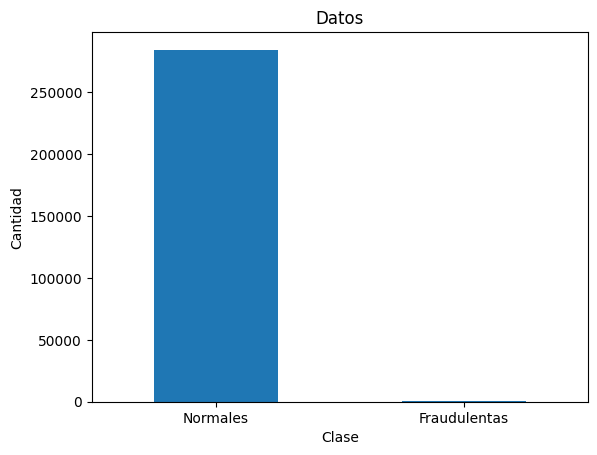

In [35]:
datos = basedatos['Class'].value_counts(sort=True)
datos.plot(kind = 'bar', rot=0)
plt.xticks(range(2),['Normales','Fraudulentas'])
plt.title("Datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

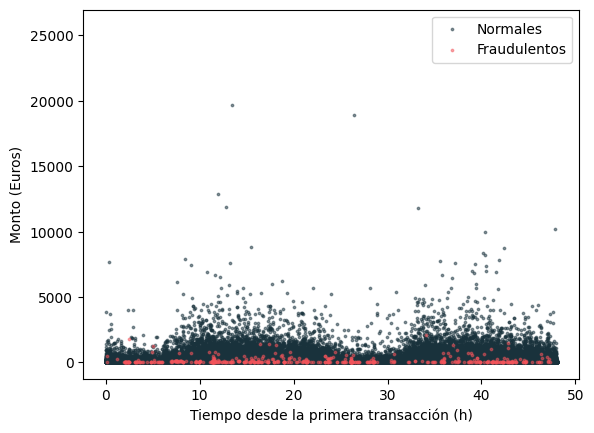

In [36]:
normales = basedatos[basedatos.Class==0]
fraudulentos = basedatos[basedatos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount, alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()

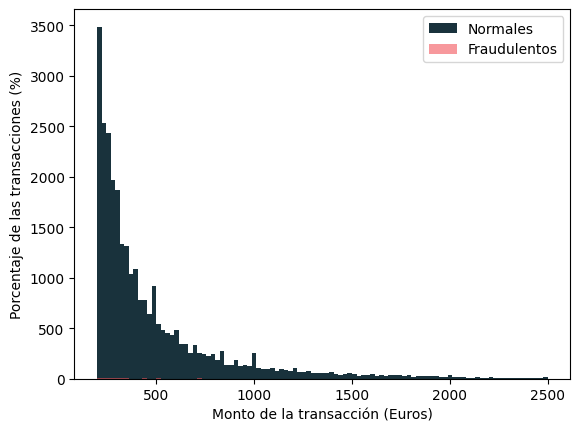

In [37]:
bins = np.linspace(200, 2500, 100)
plt.hist(normales.Amount, bins, alpha=1,
    label='Normales', color='#19323C')
plt.hist(fraudulentos.Amount, bins, alpha=0.6,
    label='Fraudulentos', color='#F2545B')
plt.legend(loc='upper right')
plt.xlabel("Monto de la transacción (Euros)")
plt.ylabel("Porcentaje de las transacciones (%)")
plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler

basedatos.drop(['Time'],axis = 1, inplace =True)
basedatos['Amount'] = StandardScaler().fit_transform(basedatos['Amount'].values.reshape(-1,1))

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split( basedatos,
                                    test_size = 0.2,
                                    random_state = 42
                                  )

X_train = X_train[X_train.Class == 0] # Usaremos unicamente la clase O (Transaciones normales)
X_train = X_train.drop(['Class'],axis= 1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis= 1)
X_test = X_test.values


In [40]:
dim_entrada = X_train.shape[1]
print(dim_entrada)

29


In [41]:
# Capa de entrada
capa_entrada = Input(shape = (dim_entrada,))

In [42]:
# Encoder
encoder = Dense(24, activation='tanh')(capa_entrada)
encoder = Dense(19, activation='tanh')(encoder)

In [43]:
# bottleneck - cuello de botella
bottleneck = Dense(14, activation='relu')(encoder)

In [44]:
# decoder
decoder = Dense(19, activation='tanh')(bottleneck)
decoder = Dense(24, activation='tanh')(decoder)
decoder = Dense(29, activation='relu')(decoder)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_6 (Dense)             (None, 24)                720       
                                                                 
 dense_7 (Dense)             (None, 19)                475       
                                                                 
 dense_8 (Dense)             (None, 14)                280       
                                                                 
 dense_9 (Dense)             (None, 19)                285       
                                                                 
 dense_10 (Dense)            (None, 24)                480       
                                                                 
 dense_11 (Dense)            (None, 29)                725 

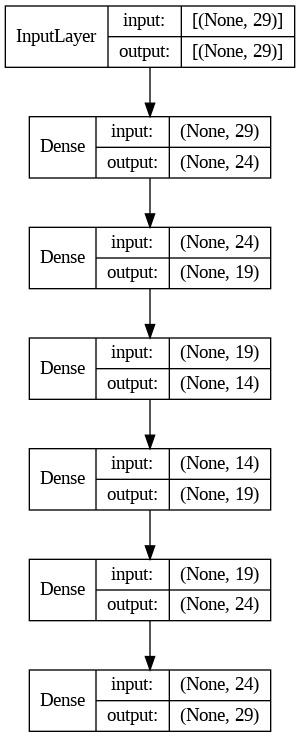

In [45]:
autoencoder = Model(inputs=capa_entrada, outputs=decoder)
print(autoencoder.summary())
plot_model(autoencoder, show_shapes=True, show_layer_names=False)

In [46]:
epoch = 50
batch = 64

learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

autoencoder.compile( optimizer = optimizer,
                     loss      = 'mse',
                     metrics   = ['accuracy'])

autoencoder.fit(X_train, X_train, epochs=epoch, batch_size=batch, shuffle=True, validation_data=(X_test,X_test), verbose=1)

Epoch 1/50
3554/3554 [==============================] - 10s 3ms/step - loss: 0.7211 - accuracy: 0.7113 - val_loss: 0.6995 - val_accuracy: 0.7755
Epoch 2/50
3554/3554 [==============================] - 8s 2ms/step - loss: 0.6569 - accuracy: 0.7912 - val_loss: 0.6817 - val_accuracy: 0.8038
Epoch 3/50
3554/3554 [==============================] - 7s 2ms/step - loss: 0.6469 - accuracy: 0.8127 - val_loss: 0.6744 - val_accuracy: 0.8166
Epoch 4/50
3554/3554 [==============================] - 8s 2ms/step - loss: 0.6403 - accuracy: 0.8197 - val_loss: 0.6617 - val_accuracy: 0.8181
Epoch 5/50
3554/3554 [==============================] - 9s 2ms/step - loss: 0.6219 - accuracy: 0.8362 - val_loss: 0.6535 - val_accuracy: 0.8230
Epoch 6/50
3554/3554 [==============================] - 7s 2ms/step - loss: 0.6160 - accuracy: 0.8481 - val_loss: 0.6498 - val_accuracy: 0.8488
Epoch 7/50
3554/3554 [==============================] - 9s 2ms/step - loss: 0.6135 - accuracy: 0.8531 - val_loss: 0.6448 - val_accuracy

In [47]:
X_pred = autoencoder.predict(X_test)

1781/1781 [==============================] - 2s 1ms/step


In [48]:
ecm = np.mean(np.power(X_test-X_pred,2), axis = 1)

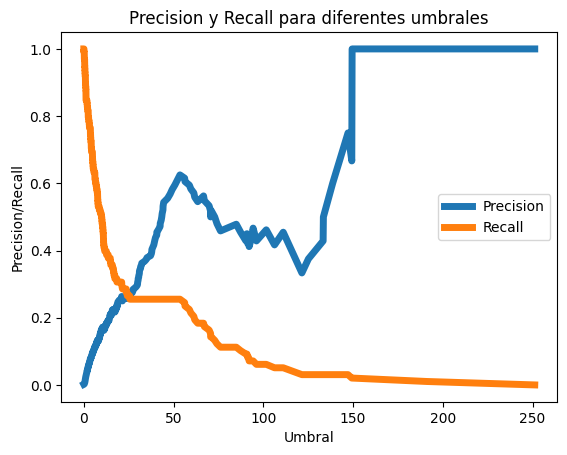

In [50]:
from sklearn.metrics import precision_recall_curve
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [53]:
umbral = 0.9
Y_pred = [1 if e > umbral else 0 for e in ecm]

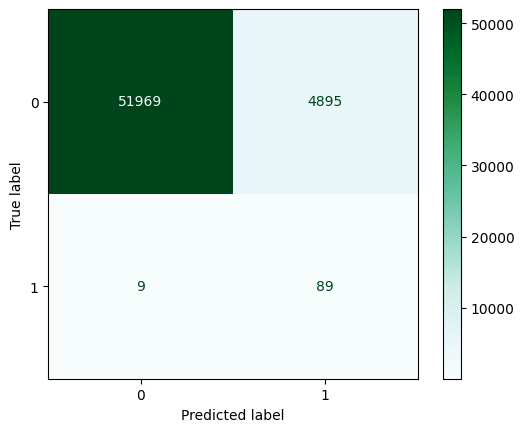

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matriz = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(matriz)
disp.plot(cmap=plt.cm.BuGn)